# EXP6 네이버 영화 리뷰 감정 분석 도전하기! 


* exp도 어느새 6번으로 접어들었다. 이번시간에는 텍스트 데이터를 벡터화 해, 텍스트 데이터를 워드 임베딩이 무엇인가에 대해 배우고, IMDB 데이터셋과 구글의 Word2Vec 을 가져와 모델을 학습시켜보고, 제시한 단어와 비슷한 단어를 유추하는 모델을 만들어 보았다.   


* 예제에서 했던 부분을 응용해, 네이버 영화 리뷰의 감성분석을 하는 모델을 만들어보자. 

----




# 루브릭 평가 기준 

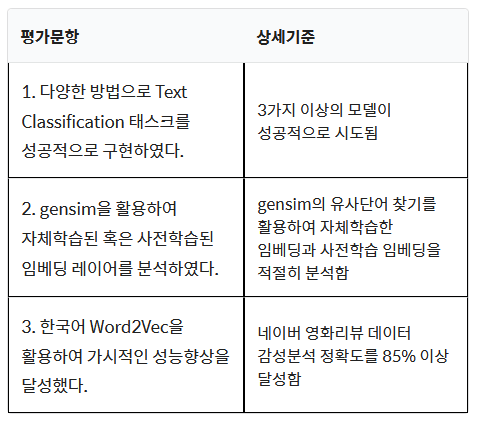



----



# 목차 

## 1. 데이터 준비와 확인¶

## 2. 데이터로더 구성

## 3. 모델 구성을 위한 데이터

## 4. 모델 구성 및 validation set 구성

## 5. 모델 훈련 개시

## 6. Loss, Accuracy 그래프 시각화

## 7. 학습된 Embedding 레이어 분석

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

## Exp를 마무리 하며

## 참고 페이지



----




# 1. 데이터 준비와 확인


* 이번 프로젝트에서 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된    [Naver sentiment movie corpus](https://github.com/e9t/nsmc) 입니다. 


* 파일 다운로드 필요 없이, ```cloud shell``` 에서 해당 파일의 심볼릭 링크를 연결합니다. 

In [8]:
# 심볼릭 링크 연결 
# $ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

In [282]:
# 필요한 모듈 모아보기! 

import pandas as pd
from pandas import DataFrame as df 
import numpy as np
import matplotlib.pyplot as plt

from konlpy.tag import Mecab # 형태소 분석기 
#문자열이나 list 요소를 카운팅하여 많은 순으로 딕셔너리 형태로 리턴하는 모듈 
from collections import Counter  

from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

import tensorflow as tf
import os 

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dropout, Dense

In [10]:
#연결이 잘 됬는지, 읽어와 봅시다!


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data[:20]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


## 1-2 데이터셋 정보 확인하기 

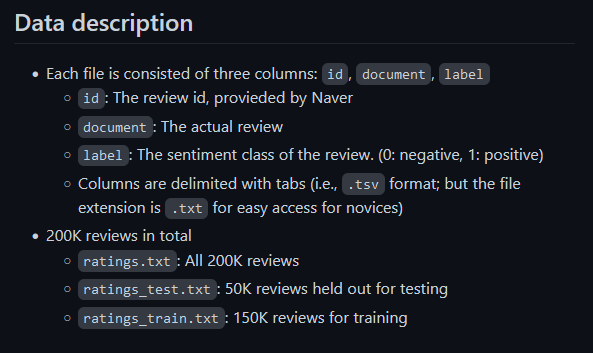
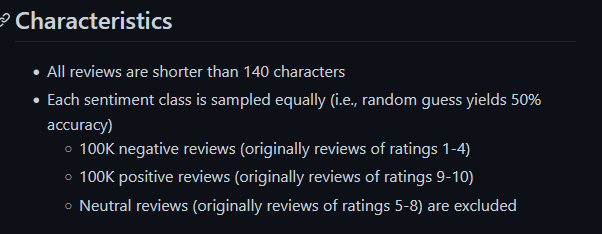

* 특성은 ```id```, ```document```, ```label``` 총 3가지. 
    * id : 리뷰 쓴 사람의 id를 숫자로 적어둔 것 같음
    * document : 리뷰 내용 
    * label : target data, 리뷰에대한 라벨이 달려있음. (긍정 : 1, 부정 : 0) 


* NSMC 데이터셋은 총 200K, 20만개, test데이터 5만개, train data 15만개로 이루어졌다. 
    * 20만개의 총 데이터 셋 중 긍정 리뷰와 부정 리뷰의 데이터 비율은 1:1.  

* document의 글자수는 140자보다 작다. 




----




# 2. 데이터로더 구성

* word_to_index 및 여러 편의 기능을 제공하던 IMDB 데이터셋과는 달리, NSMC 데이터셋은 전-혀 가공되지않은 텍스트 파일로 이루어져있기 때문에, LMS 안에서 했던 과정을 직접 해 줘야..합니다.. 

* 만, 하나하나 짜기엔 어려움이 있어, 예시 문항에 있는 코드를 빌려와서 무슨 역할을 하는지 주석 처리 해 보았습니다.


    * 데이터의 중복 제거 v
    * NaN 결측치 제거 v
    * 한국어 토크나이저로 토큰화 v
    * 불용어(Stopwords) 제거 v
    * 사전word_to_index 구성 v
    * 텍스트 스트링을 사전 인덱스 스트링으로 변환 v
    * X_train, y_train, X_test, y_test, word_to_index 리턴 v

In [11]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 단어 사전에 등재할 단어 개수 10,000개 
    # drop_duplicates : 데이터의 중복 제거 , dropna : NaN 결측치 제거 
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    #사전word_to_index 구성 
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    #vocab에 0 = 패딩용 단어, 1 = 문장의 시작지점, 2 = 사전에 없는 단어 라벨링. 
    vocab = ['<PAD>', '<BOS>', '<UNK>','<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # word_to_index에 들어있는 단어가 아니라면 <UNK>를 붙여주세요 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 학습용, test용 데이터 나누기    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

# 텍스트 스트링을 사전 인덱스 스트링으로 변환
index_to_word = {index:word for word, index in word_to_index.items()}

print('아따 길구만!')

아따 길구만!


In [12]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [13]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

In [14]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [15]:
get_decoded_sentence(X_train[0], index_to_word)

'더 빙 . . 진짜 짜증 나 네요 목소리'

In [16]:
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [17]:
print('\'더\' 의 인덱스 번호 :',word_to_index['더'])
print('\'빙\' 의 인덱스 번호 :',word_to_index['빙'])
print('\'더빙\' 의 인덱스 번호 :',word_to_index['더빙'])

'더' 의 인덱스 번호 : 74
'빙' 의 인덱스 번호 : 919
'더빙' 의 인덱스 번호 : 982


* <의문점> 더빙 이라는 단어가 사전에 982 번으로 있는데, 왜 더랑 빙이랑 나눠진걸까? 

내 생각 -> index 번호를 확인 해 봤을 때, '더' 와 '빙' 이 '더빙' 보다 사전에 먼저 등재가 됬기 때문에 train data 0번째를 출력했을 때, 따로 출력된게 아닐까? 




----





# 3. 모델 구성을 위한 데이터


###  &nbsp; &nbsp;해야 할 것!
* 데이터셋 내 문장 길이 분포 확인 
* 확인 된 길이 분포로 적절한 최대 문장 길이 지정
* pad_sequences 패딩 추가 

## 3-1 데이터셋 내 문장 길이 분포 확인 및 문장길이 지정



* 문장 길이의 적절한 값을 찾아주기 위해, 데이터셋 분포를 확인 해 봅시다. 
* 적절한 문장길이를 찾아주지 못 한다면, 짧은 문장에 패딩이 너무 많이   
  들어갈 수 있기 때문에 문장 길이의 적당한 값을 찾아줘야한다. 

In [18]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


## 3-2 문장 길이 조정하고, 패딩 설정하기 


*  ```pad_sequences``` 를 이용해 문장 길이를 3-1에서 찾은 maxlen 값으로 맞춰주고, padding도 넣어주자.  
* RNN의 경우, 입력 데이터가 순차적으로 처리되기 때문에, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 주기 때문에, 앞쪽에 적용해야한다. 
* padding은 모델 설정값 줄 때 변수로 따로 빼면..? 모델 2개 만들 필요가 없겠지?

In [19]:
# 문장 길이와 패딩 적용하기 
# 모델 적용시, padding_where 변수로 앞쪽 - 'pre', 뒤쪽 - 'post' 을 결정할 수 있게. 
# 일단 default값으로 'pre' 
padding_where = 'pre'

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
       value=word_to_index["<PAD>"],padding=padding_where, maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
       value=word_to_index["<PAD>"],padding=padding_where, maxlen=maxlen)

print('padding 적용 완료!')

padding 적용 완료!




----



# 4. 모델 구성 및 validation set 구성

* 우선 EXP에서 소개된 세 모델을 가지고 와서 모델 구성 및 validation set을 구성해보기로 합니다. 

##  &nbsp; &nbsp; 4-1 모델 구성 

In [20]:
# RNN 모델 
# padding_where = 'pre'

rnn_vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
rnn_word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(rnn_vocab_size, rnn_word_vector_dim, input_shape=(None,)))
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
rnn_model.add(tf.keras.layers.LSTM(8))   
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [21]:
# 1-D CNN 모델
# padding_where = 'post'

cnn1d_vocab_size = 10000  # 어휘 사전의 크기입니다
cnn1d_word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

cnn1d_model = tf.keras.Sequential()
cnn1d_model.add(tf.keras.layers.Embedding(cnn1d_vocab_size, cnn1d_word_vector_dim, input_shape=(None,)))
cnn1d_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn1d_model.add(tf.keras.layers.MaxPooling1D(5))
cnn1d_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn1d_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn1d_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn1d_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn1d_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [22]:
# GlobalMaxPooling1D 모델 / 대문자를 따서 gmp 라 칭하겠습니다 :) 
# padding_where = 'post'

gmp_vocab_size = 10000  # 어휘 사전의 크기입니다
gmp_word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

gmp_model = tf.keras.Sequential()
gmp_model.add(tf.keras.layers.Embedding(gmp_vocab_size, gmp_word_vector_dim, input_shape=(None,)))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


##  &nbsp; &nbsp; 4-2 데이터셋 나누기


* Numpy 슬라이싱 기능을 이용해 데이터를 나눠줍니다.
* 훈련 데이터 146,182 개 중, 49,157 개를 validation set으로 사용합니다.

In [23]:
# validation set 49157건 분리
X_val = X_train[:49157]   
y_val = y_train[:49157]

# validation set을 제외한 나머지 = train data 
partial_X_train = X_train[49157:]  
partial_y_train = y_train[49157:]

print('훈련용 데이터 : ', partial_X_train.shape)
print('훈련용 정답 데이터 : ', partial_y_train.shape)
print()
print('검증용 데이터 : ', X_val.shape)
print('검증용  정답 데이터 : ', y_val.shape)

훈련용 데이터 :  (97025, 41)
훈련용 정답 데이터 :  (97025,)

검증용 데이터 :  (49157, 41)
검증용  정답 데이터 :  (49157,)


In [24]:
# 데이터 타입 확인 

print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>




----



# 5. 모델 훈련 개시

##  &nbsp; &nbsp; 5-1 모델 훈련하기

In [25]:
# RNN 모델 훈련하기 
padding_where = 'pre'

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20

rnn_history = rnn_model.fit(partial_X_train,partial_y_train,epochs=epochs,
                    batch_size=512,validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
190/190 [==============================] - 5s 8ms/step - loss: 0.5378 - accuracy: 0.7476 - val_loss: 0.3791 - val_accuracy: 0.8410
Epoch 2/20
190/190 [==============================] - 1s 6ms/step - loss: 0.3502 - accuracy: 0.8532 - val_loss: 0.3505 - val_accuracy: 0.8485
Epoch 3/20
190/190 [==============================] - 1s 6ms/step - loss: 0.3186 - accuracy: 0.8683 - val_loss: 0.3501 - val_accuracy: 0.8495
Epoch 4/20
190/190 [==============================] - 1s 6ms/step - loss: 0.3014 - accuracy: 0.8782 - val_loss: 0.3491 - val_accuracy: 0.8510
Epoch 5/20
190/190 [==============================] - 1s 6ms/step - loss: 0.2865 - accuracy: 0.8854 - val_loss: 0.3527 - val_accuracy: 0.8496
Epoch 6/20
190/190 [==============================] - 1s 6ms/step - loss: 0.2741 - accuracy: 0.8916 - val_loss: 0.3553 - val_accuracy: 0.8500
Epoch 7/20
190/190 [==============================] - 1s 6ms/step - loss: 0.2616 - accuracy: 0.8980 - val_loss: 0.3659 - val_accuracy: 0.8466
Epoch 

In [26]:
# 1-D CNN 모델 훈련하기 
padding_where = 'post'

cnn1d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20

cnn1d_history = cnn1d_model.fit(partial_X_train,partial_y_train,epochs=epochs,
                    batch_size=512,validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
190/190 [==============================] - 3s 6ms/step - loss: 0.5416 - accuracy: 0.7176 - val_loss: 0.3755 - val_accuracy: 0.8346
Epoch 2/20
190/190 [==============================] - 1s 5ms/step - loss: 0.3397 - accuracy: 0.8555 - val_loss: 0.3471 - val_accuracy: 0.8496
Epoch 3/20
190/190 [==============================] - 1s 5ms/step - loss: 0.3020 - accuracy: 0.8739 - val_loss: 0.3478 - val_accuracy: 0.8473
Epoch 4/20
190/190 [==============================] - 1s 5ms/step - loss: 0.2767 - accuracy: 0.8863 - val_loss: 0.3470 - val_accuracy: 0.8511
Epoch 5/20
190/190 [==============================] - 1s 5ms/step - loss: 0.2511 - accuracy: 0.8984 - val_loss: 0.3554 - val_accuracy: 0.8498
Epoch 6/20
190/190 [==============================] - 1s 5ms/step - loss: 0.2244 - accuracy: 0.9135 - val_loss: 0.3745 - val_accuracy: 0.8462
Epoch 7/20
190/190 [==============================] - 1s 5ms/step - loss: 0.1934 - accuracy: 0.9275 - val_loss: 0.3983 - val_accuracy: 0.8469
Epoch 

In [27]:
# GlobalMaxPooling1D 모델 훈련하기 
padding_where = 'post'

gmp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20

gmp_history = gmp_model.fit(partial_X_train,partial_y_train,epochs=epochs,
                    batch_size=512,validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
190/190 [==============================] - 1s 4ms/step - loss: 0.6395 - accuracy: 0.6694 - val_loss: 0.5359 - val_accuracy: 0.7955
Epoch 2/20
190/190 [==============================] - 1s 4ms/step - loss: 0.4459 - accuracy: 0.8272 - val_loss: 0.3913 - val_accuracy: 0.8337
Epoch 3/20
190/190 [==============================] - 1s 4ms/step - loss: 0.3495 - accuracy: 0.8562 - val_loss: 0.3606 - val_accuracy: 0.8422
Epoch 4/20
190/190 [==============================] - 1s 4ms/step - loss: 0.3106 - accuracy: 0.8737 - val_loss: 0.3548 - val_accuracy: 0.8450
Epoch 5/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2847 - accuracy: 0.8856 - val_loss: 0.3560 - val_accuracy: 0.8457
Epoch 6/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2639 - accuracy: 0.8959 - val_loss: 0.3619 - val_accuracy: 0.8460
Epoch 7/20
190/190 [==============================] - 1s 4ms/step - loss: 0.2466 - accuracy: 0.9045 - val_loss: 0.3710 - val_accuracy: 0.8456
Epoch 

##  &nbsp; &nbsp; 5-2 훈련한 모델 test set으로 평가하기  

In [28]:
print('-'*20)
print()
rnn_results = rnn_model.evaluate(X_test, y_test, verbose=2)
print('RNN 모델 결과 :', rnn_results)
print()

print('-'*20)
print()
cnn1d_results = cnn1d_model.evaluate(X_test, y_test, verbose=2)
print('cnn1d 모델 결과 :', cnn1d_results)
print()

print('-'*20)
print()
gmp_results = gmp_model.evaluate(X_test, y_test, verbose=2)
print('gmp 모델 결과 :', gmp_results)
print()


--------------------

1537/1537 - 3s - loss: 0.5683 - accuracy: 0.8274
RNN 모델 결과 : [0.5682597756385803, 0.8274304866790771]

--------------------

1537/1537 - 2s - loss: 1.0694 - accuracy: 0.8171
cnn1d 모델 결과 : [1.069355845451355, 0.8170759081840515]

--------------------

1537/1537 - 2s - loss: 0.5786 - accuracy: 0.8192
gmp 모델 결과 : [0.57858806848526, 0.8191508650779724]






----




# 6. Loss, Accuracy 그래프 시각화

##  &nbsp; &nbsp; 6-1 RNN 모델 Loss, Accuracy 시각화

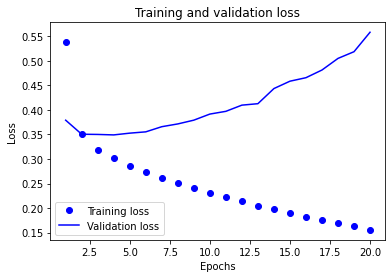

In [29]:
rnn_hidi = rnn_history.history

# Loss 그래프 시각화 
rnn_acc = rnn_hidi['accuracy']
rnn_val_acc = rnn_hidi['val_accuracy']
rnn_loss = rnn_hidi['loss']
rnn_val_loss = rnn_hidi['val_loss']

epochs = range(1, len(rnn_acc) + 1)

# 'bo' =  파란색 점 
plt.plot(epochs, rnn_loss, 'bo', label='Training loss')

#'b' = 파란 실선
plt.plot(epochs, rnn_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

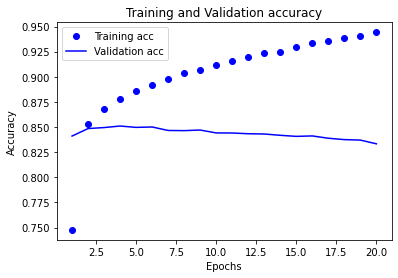

In [30]:
# Accuracy 그래프 시각화 

plt.clf() # 그림을 초기화 합니다.

plt.plot(epochs, rnn_acc, 'bo', label='Training acc')
plt.plot(epochs, rnn_val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##  &nbsp; &nbsp; 6-2 1-D CNN 모델 Loss, Accuracy 시각화

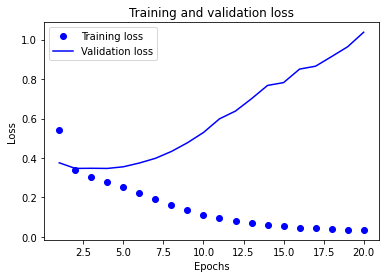

In [31]:
cnn_hidi = cnn1d_history.history

# Loss 그래프 시각화 
cnn_acc = cnn_hidi['accuracy']
cnn_val_acc = cnn_hidi['val_accuracy']
cnn_loss = cnn_hidi['loss']
cnn_val_loss = cnn_hidi['val_loss']

epochs = range(1, len(cnn_acc) + 1)

# 'bo' =  파란색 점 
plt.plot(epochs, cnn_loss, 'bo', label='Training loss')

#'b' = 파란 실선
plt.plot(epochs, cnn_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

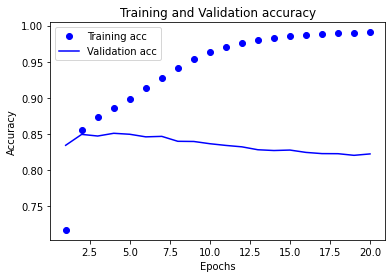

In [32]:
# Accuracy 그래프 시각화 

plt.clf() # 그림을 초기화 합니다.

plt.plot(epochs, cnn_acc, 'bo', label='Training acc')
plt.plot(epochs, cnn_val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##  &nbsp; &nbsp; 6-3 GlobalMaxPooling1D 모델 Loss, Accuracy 시각화

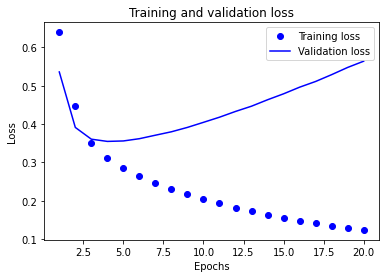

In [33]:
gmp_hidi = gmp_history.history

# Loss 그래프 시각화 
gmp_acc = gmp_hidi['accuracy']
gmp_val_acc = gmp_hidi['val_accuracy']
gmp_loss = gmp_hidi['loss']
gmp_val_loss = gmp_hidi['val_loss']

epochs = range(1, len(gmp_acc) + 1)

# 'bo' =  파란색 점 
plt.plot(epochs, gmp_loss, 'bo', label='Training loss')

#'b' = 파란 실선
plt.plot(epochs, gmp_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

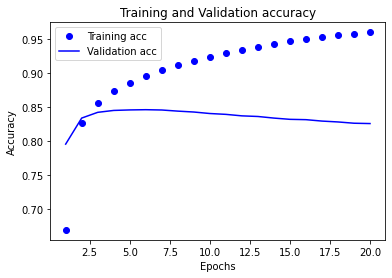

In [34]:
# Accuracy 그래프 시각화 

plt.clf() # 그림을 초기화 합니다.

plt.plot(epochs, gmp_acc, 'bo', label='Training acc')
plt.plot(epochs, gmp_val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7. 학습된 Embedding 레이어 분석

##  &nbsp; &nbsp; 7-1 rnn_model

* embedding 파라미터 저장하기 
* word vector 활용하기 - feat.gensim

In [35]:
# rnn_model
rnn_embedding_layer = rnn_model.layers[0]
rnn_weights = rnn_embedding_layer.get_weights()[0]
print(rnn_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [36]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
rnn_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/rnn_word2vec.txt'
f = open(rnn_word2vec_file_path, 'w')
f.write('{} {}\n'.format(rnn_vocab_size-4, rnn_word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
rnn_vectors = rnn_model.get_weights()[0]
for i in range(4,rnn_vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(rnn_vectors[i, :])))))
f.close()

print('저장 완료!')

저장 완료!


In [37]:
# 임베딩 파라미터 활용하기 

rnn_word_vectors = Word2VecKeyedVectors.load_word2vec_format(rnn_word2vec_file_path, binary=False)
rnn_vector = rnn_word_vectors['대박'] # 영어가 없기 때문에 한글로 입력 해 줘야함! 
rnn_vector

array([ 0.13893843,  0.10172984, -0.10479816,  0.12529384,  0.07645668,
        0.03261885, -0.1904207 , -0.10765701, -0.14463808, -0.13200027,
        0.0719085 , -0.12817329, -0.114555  , -0.14036271,  0.11575121,
       -0.0028344 ], dtype=float32)

In [38]:
# gensim 을 이용한 유사도 체크 
rnn_word_vectors.similar_by_word("대박")

[('깎아내리', 0.9752744436264038),
 ('짙', 0.9685516953468323),
 ('히스', 0.9662830233573914),
 ('한층', 0.9590405225753784),
 ('케미', 0.958183765411377),
 ('아키라', 0.9569090008735657),
 ('감탄', 0.9567035436630249),
 ('슬펐', 0.9566165208816528),
 ('완벽', 0.9545639157295227),
 ('명복', 0.9543865919113159)]

##  &nbsp; &nbsp; 7-2 1-D CNN 모델

* embedding 파라미터 저장하기 
* word vector 활용하기 - feat.gensim

In [39]:
# cnn1d_model
cnn1d_embedding_layer = cnn1d_model.layers[0]
cnn1d_weights = cnn1d_embedding_layer.get_weights()[0]
print(cnn1d_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [40]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
cnn1d_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/cnn1d_word2vec.txt'
f = open(cnn1d_word2vec_file_path, 'w')
f.write('{} {}\n'.format(cnn1d_vocab_size-4, cnn1d_word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
cnn1d_vectors = cnn1d_model.get_weights()[0]
for i in range(4,cnn1d_vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(cnn1d_vectors[i, :])))))
f.close()

print('저장 완료!')

저장 완료!


In [41]:
# 임베딩 파라미터 활용하기 

cnn1d_word_vectors = Word2VecKeyedVectors.load_word2vec_format(cnn1d_word2vec_file_path, binary=False)
cnn1d_vector = cnn1d_word_vectors['대박'] # 영어가 없기 때문에 한글로 입력 해 줘야함! 
cnn1d_vector

array([ 0.039374  ,  0.16920497,  0.16574742,  0.00164253,  0.1127745 ,
       -0.1004431 , -0.0995655 , -0.03992726, -0.04233261,  0.15461425,
       -0.07021619, -0.20820665, -0.0929801 ,  0.12385007,  0.04156624,
        0.0048484 ], dtype=float32)

In [42]:
# gensim 을 이용한 유사도 체크 
cnn1d_word_vectors.similar_by_word("대박")

[('저격', 0.9000811576843262),
 ('갑시다', 0.8983970284461975),
 ('후속', 0.8923985958099365),
 ('보듬', 0.8796246647834778),
 ('서민', 0.8790039420127869),
 ('엉엉', 0.8786578178405762),
 ('원본', 0.8741585612297058),
 ('예민', 0.8737156391143799),
 ('꺄', 0.8735411167144775),
 ('사자', 0.8665894269943237)]

##  &nbsp; &nbsp; 7-3 GlobalMaxPooling1D 모델

* embedding 파라미터 저장하기 
* word vector 활용하기 - feat.gensim

In [43]:
# gmp_model 

gmp_embedding_layer = gmp_model.layers[0]
gmp_weights = gmp_embedding_layer.get_weights()[0]
print(gmp_weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [44]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
gmp_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/gmp_word2vec.txt'
f = open(gmp_word2vec_file_path, 'w')
f.write('{} {}\n'.format(gmp_vocab_size-4, gmp_word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
gmp_vectors = gmp_model.get_weights()[0]
for i in range(4,gmp_vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(gmp_vectors[i, :])))))
f.close()

print('저장 완료!')

저장 완료!


In [45]:
# 임베딩 파라미터 활용하기 

gmp_word_vectors = Word2VecKeyedVectors.load_word2vec_format(gmp_word2vec_file_path, binary=False)
gmp_vector = gmp_word_vectors['대박'] # 영어가 없기 때문에 한글로 입력 해 줘야함! 
gmp_vector

array([-0.2740265 ,  0.03088474, -0.2976206 , -0.03994615, -0.05391282,
        0.00619487,  0.1064515 , -0.03698393, -0.03348894, -0.05702455,
        0.03400817,  0.13802676, -0.22855347,  0.16400017, -0.20134625,
       -0.19959547], dtype=float32)

In [46]:
# gensim 을 이용한 유사도 체크 
gmp_word_vectors.similar_by_word("대박")

[('미치', 0.7993509769439697),
 ('영화사', 0.7653915882110596),
 ('먼가', 0.754611611366272),
 ('마녀', 0.7409251928329468),
 ('였으면', 0.716974675655365),
 ('이야말로', 0.6937915086746216),
 ('감사', 0.6902768611907959),
 ('기동대', 0.6879042983055115),
 ('모자르', 0.6818786263465881),
 ('남녀', 0.6810275912284851)]

##  &nbsp; &nbsp; 7-4 gensim 을 이용한 유사도 체크 

In [106]:
print()
print('RNN 모델의 경우')
print('-'*20)
rnn_word_vectors.similar_by_word("영화")


RNN 모델의 경우
--------------------


[('가능', 0.8562612533569336),
 ('무엇', 0.8547843098640442),
 ('그것', 0.8510684967041016),
 ('드라마', 0.8479664921760559),
 ('드', 0.8293106555938721),
 ('던데', 0.8284571170806885),
 ('개취', 0.8210386633872986),
 ('헤헤', 0.8206375241279602),
 ('싶', 0.8168586492538452),
 ('도입부', 0.8165989518165588)]

In [105]:
print()
print('1-D CNN 모델의 경우 ')
print('-'*20)
cnn1d_word_vectors.similar_by_word("영화")


1-D CNN 모델의 경우 
--------------------


[('학년', 0.7735331654548645),
 ('중요', 0.7191006541252136),
 ('안전', 0.7190299034118652),
 ('블', 0.7175517082214355),
 ('고', 0.7161295413970947),
 ('힘겹', 0.7054141759872437),
 ('간접', 0.6997145414352417),
 ('서영희', 0.697860598564148),
 ('다', 0.680226743221283),
 ('라디오스타', 0.6761251091957092)]

In [104]:
print()
print('-'*20)
print('GlobalMaxPooling1D 모델의 경우')
gmp_word_vectors.similar_by_word("영화")


--------------------
GlobalMaxPooling1D 모델의 경우


[('다', 0.994683027267456),
 ('.', 0.9911369681358337),
 ('하', 0.9845334887504578),
 ('음', 0.9832894802093506),
 ('보', 0.9777811765670776),
 ('을', 0.977500855922699),
 ('만드', 0.972870945930481),
 ('이런', 0.972858190536499),
 ('했', 0.9705963134765625),
 ('많이', 0.9695299863815308)]




----




# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선


##  &nbsp; &nbsp; 8-1 gensim 버전 다운그레이드 


* 한국어 Word2Vec의 버전이, lms 노드의 버전과 달라 버전을 다운그레이드 해 줘야한다.
* 우선, 현재 gensim의 버전은 '4.1.2' 
* 3.X.X 대로 낮춰줘야 오류가 없기 때문에 다운그레이드 해 줍시다! 

In [50]:
import gensim
gensim.__version__ 

'3.8.3'

In [51]:
!pip install gensim  
!pip install --upgrade gensim==3.8.3 #[버전 다운그레이드 하는 코드]

In [52]:
!pip list | grep gensim

gensim                        3.8.3


In [53]:
gensim.__version__ 

'3.8.3'

##  &nbsp; &nbsp; 8-2  한국어 Word2Vec 불러오기

* [한국어 Word2Vec 다운로드 경로](https://github.com/Kyubyong/wordvectors) 에서 word2vec용 ko.bin 파일을 다운받아 가져왔다 

In [56]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

In [61]:
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [62]:
vector = word2vec['한글']
vector 

/tmp/ipykernel_2592/2012081322.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['한글']


array([ 1.6128085 , -1.1544337 , -0.5932879 ,  1.0139976 ,  0.14398324,
        0.06146022, -1.2307618 ,  1.246725  , -0.36126938, -0.58117795,
       -1.7926406 ,  1.1809887 ,  0.09327681, -2.1807477 , -0.61531913,
        0.8726902 , -1.0970036 ,  1.3963151 ,  1.0671253 , -1.8440446 ,
        0.8027888 ,  0.29326743, -0.9776343 , -0.2296304 ,  1.3892593 ,
        0.6026744 , -1.0210171 , -1.1725664 ,  0.6729586 , -0.23679246,
        0.8755139 ,  1.3650341 ,  0.55645025,  0.09423062, -1.202211  ,
        0.17125276,  0.68014663,  2.7045243 ,  2.2534132 , -0.40493518,
        0.1276657 , -2.671103  ,  2.6819725 , -0.7603048 , -2.144086  ,
        2.8544457 , -0.33210874, -1.9362477 , -0.77313316, -0.7834715 ,
        1.4361358 , -1.2351226 ,  0.07767043, -0.15594688,  0.12987676,
       -0.0743077 , -0.24870954, -1.8310938 , -0.98321086, -1.469205  ,
        0.5321793 , -1.3140066 , -1.1456997 ,  2.8354068 ,  0.19710186,
        0.63099426,  1.2202299 , -1.2086796 , -0.85067475,  0.75

In [65]:
# 제시한 단어와 연관 단어를 찾아볼까나
word2vec.similar_by_word("밥")

/tmp/ipykernel_2592/2903394802.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("밥")


[('스폰지', 0.6359171867370605),
 ('반찬', 0.6288836002349854),
 ('떡', 0.6208181381225586),
 ('계란', 0.6053064465522766),
 ('시럽', 0.6036492586135864),
 ('초콜릿', 0.6027452349662781),
 ('푸딩', 0.5942443609237671),
 ('국물', 0.5894560813903809),
 ('치킨', 0.589329719543457),
 ('비스킷', 0.5666051506996155)]

~~아 스폰지밥이라서 밥에 나온거야?~~

In [103]:
# 제시한 단어와 연관 단어를 찾아볼까나
word2vec.similar_by_word("영화")

/tmp/ipykernel_2592/695650924.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("영화")


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

* 7-4 에서 했던 유사도 체크 결과 보다 훨씬 유사한 단어, 연관있는 단어를 찾았다. 
    (밥 을 입력했을때 스폰지가 나온건 정말 생각도 못했는데) 
    
* 임베딩 레이어를 한국어 Word2Vec 으로 변경해 준다면, 위에 보다 훨신 더 좋은 결과를 얻을 수 있지 않을까?! 

##  &nbsp; &nbsp; 8-3  모델의 enbedding layer 교체하기

In [67]:
# #임베딩 레이어 교체! 오류가 있어 주석 처리 하였습니다. 
# vocab_size = 10000
# word_vector_dim = 300 #워드 벡터의 차원 수
# embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
# for i in range(4, vocab_size):
#     if index_to_word[i] in word2vec:
#         embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2592/1828759073.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2592/1828759073.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


ValueError: could not broadcast input array from shape (200,) into shape (300,)

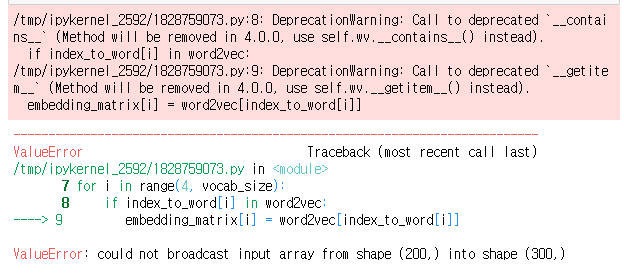



* LMS에서 했던 파라미터를 그대로 가져왔더니, could not broadcast input array from shape (200,) into shape (300,) 라는 오류가 발생하였다. 300 을 200에 집어넣을 수 없다 라는 말 같은데, 300은 ```word_vector_dim = 300``` 인것 같은데, 200은 어디서 왔느냐.. 


* 정답은 ko.bin을 다운받았던 사이트에 있었다. 
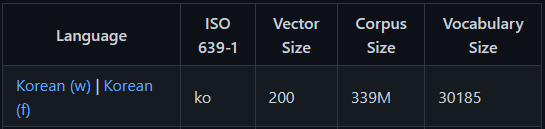

    ko.bin의 벡터 사이즈는 200, vocab_size도 30185 라고 명시되어 있다.  
    vocab_size는 문제가 없을 걸로 생각하고, word_vector_dim 만 200으로 바꿔서 해보자.

In [70]:
#임베딩 레이어 교체 
vocab_size = 10000
word_vector_dim = 200 #워드 벡터의 차원 수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

print('워드 벡터 카피 완료!')

워드 벡터 카피 완료!


/tmp/ipykernel_2592/2322596148.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2592/2322596148.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


##  &nbsp; &nbsp; 8-4 한국어 Word2Vec 로 모델 구성, 학습, 예측하기

* RNN 모델 , 1-D CNN 모델, GlobalMaxPooling1D 모델 세 모델을 구성해보겠습니다.


* 구형, 신형 구분을 위해 naming 적용. ( 구형 -> 신형)  
    * RNN 모델 : rnn_ -> rn2_
    * 1-D CNN 모델 : cnn1d_ -> cn2_
    * GlobalMaxPooling1D 모델 : gmp_ -> gp2_ 


* vocab_size, word_vector_dim 은 ```#임베딩 레이어 교체``` 시 썼던 값을 그대로 사용합니다. 

* 모델의 epoch 값은 5로 설정. 

In [185]:
# 파라미터 설정 

epochs = 10
dense = 64

###  &nbsp; &nbsp; &nbsp; &nbsp; 8-4-1 RNN 모델

In [186]:
# RNN 모델 
# padding_where = 'pre'

rn2_model = tf.keras.Sequential()
rn2_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix), 
                                        input_length=maxlen, trainable=True))



# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다.
rn2_model.add(tf.keras.layers.LSTM(128))   
rn2_model.add(Dropout(0.5))
rn2_model.add(tf.keras.layers.Dense(dense, activation='relu'))
rn2_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rn2_model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 65        
Total params: 2,176,769
Trainable params: 2,176,769
Non-trainable params: 0
_________________________________________________________________


In [187]:
#
rn2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=epochs  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

rn2_history = rn2_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1517/1517 [==============================] - 12s 7ms/step - loss: 0.4214 - accuracy: 0.8041 - val_loss: 0.3367 - val_accuracy: 0.8549
Epoch 2/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.3133 - accuracy: 0.8669 - val_loss: 0.3204 - val_accuracy: 0.8619
Epoch 3/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.2720 - accuracy: 0.8876 - val_loss: 0.3177 - val_accuracy: 0.8645
Epoch 4/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.2383 - accuracy: 0.9022 - val_loss: 0.3202 - val_accuracy: 0.8634
Epoch 5/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.2073 - accuracy: 0.9178 - val_loss: 0.3463 - val_accuracy: 0.8644
Epoch 6/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.1775 - accuracy: 0.9292 - val_loss: 0.3576 - val_accuracy: 0.8609
Epoch 7/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.1508 - accuracy: 0.9427 - val_loss: 0.3834 - val_ac

In [188]:
# 평가하기 

print('-'*20)
print()
rn2_results = rn2_model.evaluate(X_test, y_test, verbose=2)
print('RNN 모델 결과 :', rn2_results)
print()

--------------------

1537/1537 - 3s - loss: 0.4921 - accuracy: 0.8520
RNN 모델 결과 : [0.4920971393585205, 0.8520251512527466]



###  &nbsp; &nbsp; &nbsp; &nbsp; 8-4-2 1-D CNN 모델

In [202]:
# 1-D CNN 모델
# 패딩 위치 
padding_where = 'post'

cn2_model = tf.keras.Sequential()
cn2_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix),# 임베딜 적용 
                                        input_length=maxlen,
                                        trainable=True))
cn2_model.add(tf.keras.layers.Conv1D(32, 7, activation='relu')) 
cn2_model.add(tf.keras.layers.MaxPooling1D(5))
cn2_model.add(Dropout(0.5))
cn2_model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
cn2_model.add(Dropout(0.5))
cn2_model.add(tf.keras.layers.GlobalMaxPooling1D())
cn2_model.add(tf.keras.layers.Dense(dense, activation='relu'))
cn2_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cn2_model.summary()


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 35, 32)            44832     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 7, 32)             0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 1, 32)             7200      
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 32)              

In [203]:
# 모델 학습 및 예측 

cn2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=epochs  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

cn2_history = cn2_model.fit(partial_X_train, partial_y_train,
                            epochs=epochs,batch_size=32,validation_data=(X_val, y_val),verbose=1)


Epoch 1/10
3033/3033 [==============================] - 17s 6ms/step - loss: 0.5610 - accuracy: 0.6926 - val_loss: 0.4060 - val_accuracy: 0.8262
Epoch 2/10
3033/3033 [==============================] - 17s 5ms/step - loss: 0.3971 - accuracy: 0.8264 - val_loss: 0.3970 - val_accuracy: 0.8447
Epoch 3/10
3033/3033 [==============================] - 17s 5ms/step - loss: 0.3537 - accuracy: 0.8491 - val_loss: 0.3623 - val_accuracy: 0.8515
Epoch 4/10
3033/3033 [==============================] - 17s 5ms/step - loss: 0.3285 - accuracy: 0.8610 - val_loss: 0.3469 - val_accuracy: 0.8544
Epoch 5/10
3033/3033 [==============================] - 17s 5ms/step - loss: 0.3115 - accuracy: 0.8693 - val_loss: 0.3476 - val_accuracy: 0.8535
Epoch 6/10
3033/3033 [==============================] - 17s 5ms/step - loss: 0.2966 - accuracy: 0.8755 - val_loss: 0.3452 - val_accuracy: 0.8551
Epoch 7/10
3033/3033 [==============================] - 17s 5ms/step - loss: 0.2831 - accuracy: 0.8819 - val_loss: 0.3404 - val_ac

In [204]:
# 평가하기 

print('-'*20)
print()
cn2_results = cn2_model.evaluate(X_test, y_test, verbose=2)
print('1-D CNN 모델 결과 : ', cn2_results)
print()

--------------------

1537/1537 - 3s - loss: 0.3476 - accuracy: 0.8501
1-D CNN 모델 결과 : [0.3475893437862396, 0.8500925898551941]



###  &nbsp; &nbsp; &nbsp; &nbsp; 8-4-3 GlobalMaxPooling1D 모델

In [328]:
padding_where = 'post'

gp2_model = tf.keras.Sequential()
gp2_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                        embeddings_initializer=Constant(embedding_matrix), 
                                        input_length=maxlen, trainable=True))
gp2_model.add(Dropout(0.5))
gp2_model.add(tf.keras.layers.GlobalMaxPooling1D())
gp2_model.add(tf.keras.layers.Dense(dense, activation='relu'))
gp2_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gp2_model.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_61 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
dropout_40 (Dropout)         (None, 41, 200)           0         
_________________________________________________________________
global_max_pooling1d_47 (Glo (None, 200)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 64)                12864     
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 65        
Total params: 2,012,929
Trainable params: 2,012,929
Non-trainable params: 0
_________________________________________________________________


In [331]:
# 모델 학습 
gp2_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=epochs  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gp2_history = gp2_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.3110 - accuracy: 0.8668 - val_loss: 0.3580 - val_accuracy: 0.8457
Epoch 2/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.3086 - accuracy: 0.8665 - val_loss: 0.3563 - val_accuracy: 0.8441
Epoch 3/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.3055 - accuracy: 0.8691 - val_loss: 0.3590 - val_accuracy: 0.8466
Epoch 4/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.3011 - accuracy: 0.8710 - val_loss: 0.3614 - val_accuracy: 0.8457
Epoch 5/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.2996 - accuracy: 0.8710 - val_loss: 0.3575 - val_accuracy: 0.8450
Epoch 6/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.2964 - accuracy: 0.8737 - val_loss: 0.3593 - val_accuracy: 0.8470
Epoch 7/20
1517/1517 [==============================] - 6s 4ms/step - loss: 0.2937 - accuracy: 0.8745 - val_loss: 0.3522 - val_accuracy:

In [332]:
# 평가하기 

print('-'*20)
print()
gp2_results = gp2_model.evaluate(X_test, y_test, verbose=2)
print('GlobalMaxPooling1D 모델 결과 :', gp2_results)
print()

--------------------

1537/1537 - 2s - loss: 0.3608 - accuracy: 0.8448
GlobalMaxPooling1D 모델 결과 : [0.3607630133628845, 0.8448237180709839]



###  &nbsp; &nbsp; &nbsp; &nbsp; 8-5 embedding 적용 전, 후 비교 해 보기! 

In [333]:
compare = df(data = {'모델명':['RNN', '1-D CNN', 'GlobalMaxPooling'],
                    '임베딩 적용전':['0.8274', '0.8171', '0.8192'],
                    '임베딩 적용후':['0.8520', '0.8501', '0.8448']})
compare

,모델명,임베딩 적용전,임베딩 적용후
0,RNN,0.8274,0.8520
1,1-D CNN,0.8171,0.8501
2,GlobalMaxPooling,0.8192,0.8448


###  &nbsp; &nbsp; &nbsp; &nbsp; 8-6 모델 저장하기 

In [334]:
rn2_model.save("EXP6_kr_rn2.h5")
cn2_model.save("EXP6_kr_cn2.h5")
gp2_model.save("EXP6_kr_gp2.h5")



-----




# Exp를 마무리 하며

## 1. 오류 해결 


* 막 코드를 어찌어찌 해서 고친게 아니라, 이번 익스를 진행 하면서 봤던 에러 상황, 그리고 해결 했던 방법을 적어보았다. 완벽하지 않으니 꼼꼼히 봐야겠고, 정말 모르겠다 싶으면 팀원분과 상의하는 습관을 들이자. 


* 3-2 패딩 적용하기 부분에서 train data와 test data에 동일하게 패딩을 적용 해 줘야했는데, 노션에 정리 하면서도 변수 이름을 보지 않고, 코드만 보고 같은 데이터다! 라고 판단해, 코드를 지웠었다. 변수 이름만 잘 봤어도 X_test 변수를 Numpy 형식 배열로 바꾸려는 방법은 찾아보지 않았을 것이다. 노션 필기도, 공부도, 익스도, ```왜 이게 이렇게 적혀있을까?``` 라는 의문을 가지면서 해야겠다고 생각했다.


* 8-2, 가져온 한국어 Word2Vec 파일을 적용해 주기위해, lms 상에 있던 코드를 그대로 가져왔었다. gensim 다운그레이드를 미리 해 줬기때문에 다른 부분은 문제가 없었으나,   
```word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True,limit=3000000)``` 
부분을 실행하면 ```utf-8' codec can't decode byte 0x80 in position 0: invalid start byte```
라는 오류가 발생하였다.   
오류 코드로 검색 해 본 결과, [해결방법](https://stackoverflow.com/questions/27659985/error-utf8-codec-cant-decode-byte-0x80-in-position-0-invalid-start-byte) 을 통해 ```load_word2vec_format()``` 대신 ```load()``` 를 사용해야 한다는 점을 배웠다. 

## 2. 이번 노드를 진행하면서 아쉬웠던 점

* 노트북엔 없지만 한국어 word2vec 적용하고 적합도 그래프를 그려봤었는데, 영화분석 데이터의 그래프(4번)와 별반 달라진게 없어서 지웠다. 조금 더 여유로웠다면, 이유도 분석해보고 원인도 파악해서 개선 해 봤을텐데 정말정말 아쉽다.  
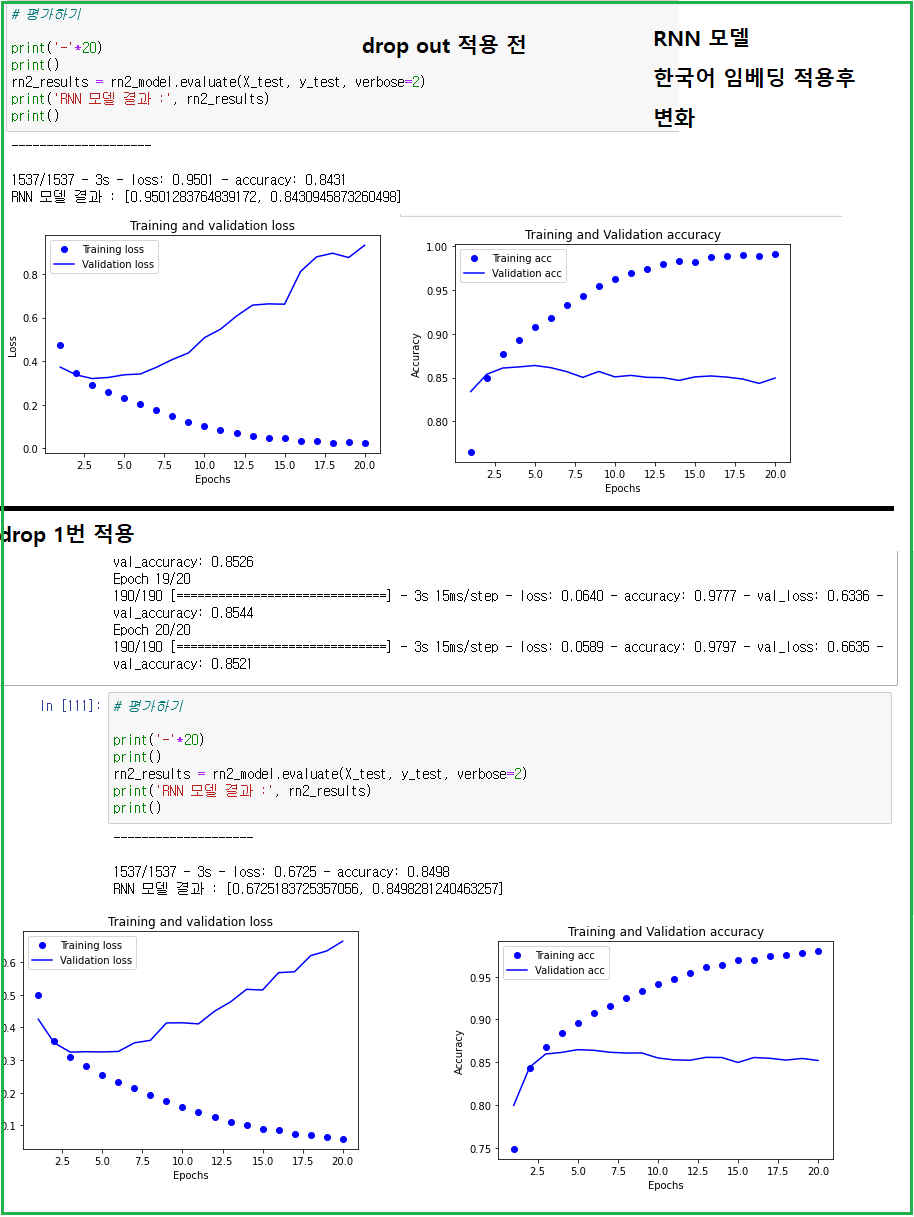    


* 4.loss, Accuracy 시각화 부분. 그래프 그리는 부분이 중복되길래, exp5에서 했던 자주 쓰는 기능 함수화를 도전해 봤었는데, loss 그래프 그릴땐 문제 없이 되서 엄청 기뻤다. 와 내가 이걸 한방에 함수화 했다! 라는 기분에.. 그치만 그렇게 녹록치않았죠.. Accuracy 그래프 그리는 코드는, loss 그래프를 그린 다음에 그릴 수 있게 되어있었는데, 정확도 그래프에 필요한 변수가 함수안에 들어가니 호출을 할 수 없었다.. 분명 배웠던 부분이지만, 했을 당시엔 생각이 나지 않아 왜 안될까 하고 30분은 고민했었던것 같다. 그래프 2개를 나타내는 법을 찾아서 적용 했더라면, 이렇게 고민하지도 않았을테고, 함수화로 코드가 조금 더 깔끔했을텐데.. 너무나도 아쉬운부분.. 


* 그래도 이전 노드에서 봤었던, epoch와 dense 값을 변수로 지정해, 한꺼번에 바꿔줬던건 내가 생각해도 정말 대견하다 느꼈다. Pandas DataFrame 생각해서, 정확도 표 그린것도 정말 대단하다고 생각한다. 비록 값을 불러와 한게 아니라, 내가 일일이 붙여넣었지만.. 그래도 1,2주 전까지만 해도, 따라가는거에 바빠서 어떻게 해 볼 생각조차 못 하고 복사하고 붙여넣은 다음 지나가기 일쑤였는데.. 노드를 점점 거치고, exp를 하나하나 헤쳐나가다 보니 조금씩 발전하는것 같아 보여 조금은 기뻤다. 


* 제시한 문장이 긍정인지 부정인지 분석하는 부분을 적용하지 못했다. 
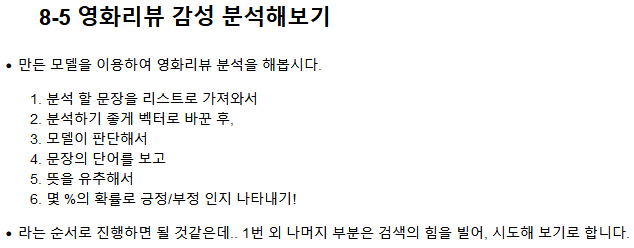  
 &nbsp; &nbsp; 적용하는 방법은 검색하다보니 찾았다. (참고페이지 - 데이터셋 관련 부분) 하지만 적용하지 못했다. 사진처럼 어떻게 하면 되겠다! 라고 생각해 놓고선.. 이번 노드 하면서 내가 빼먹어서 오류가 났던 부분이 한두군데가 아니라, 이번에도 시도하다가 오류나고, 고치다보면 시간에 맞춰서 제출 할 수 없을 것 같아 다음 기회로 미뤘다. 정확도로 판단하는 것이 아니라 정말 잘 표현 됬는지 확인 해 볼 수 있었을텐데.. 좀 더 공부해서 적용 해 보는걸로..

* 노드 제목을 봤을땐, 어떤식으로 감성을 분석하는걸까.. 했지만 역시 n번의 처리 후에 분석. 세상에 쉬운건 없었다. 그치만 만화 주인공 처럼 말을 걸어서 기계에게 일을 하라고 명령하면 내가 원하는대로 척척! 할 수 있는것이 아니니, 내가 열심히 기계어를 배울 수 밖에.. 
* 좋아하는 다른 나라 사람과 대화하고 싶단 마음이 있다면 열심히 그 나라 언어를 공부하고, 관심사를 공부하게된다. 컴퓨터와 막 대화를 하거나 친구처럼 친해지려는 것은 아니지만, 이 공부를 통해 내 앞으로의 생활들에 도움이 될 수 있도록, 더 많은 것을 시도 해 볼 수 있도록 열심히 배워나가야겠다. 하다보면 ```'오늘은 날이 좋지 않으니 로또는 안사시는게 좋을 것 같습니다.'``` 라고 비슷하게라도 얘기해 주는 인공지능 구상 정돈 할 수 있지않을까? 🤣

# 참고 페이지 

* 모듈 관련  
[collections 모듈 counter 사용법](https://gorokke.tistory.com/126)    



* 데이터셋 관련  
[딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/44249)  



* 기타 의문  
[200K가 도대체 얼마란 얘기야..?](https://hanpuri.com/204)  